In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler

In [34]:
torch.manual_seed(1)

In [35]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [36]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [37]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [38]:
def paramWeights(model):
    #modelParamWgt={}
    #modelTotalWeight = 0
    for name, parameter in model.named_parameters():
                    #print(name)
                    if'weight' in name:
                        return torch.nn.utils.parameters_to_vector(parameter).detach().numpy()

In [82]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    trainAvgLoss = {}
    epoch = 0
    #pramWgtArr = []
    #modelTotalWeightArr = []
    paramWeightsDict ={}
    for epoch in range (num_epochs):
        epoch += 1
        #weight cal for each epoch
        paramWeightsDict[epoch] = paramWeights(model)

        n_correct = 0
        n_samples = 0
        lossSum =0
        train_epoch.append(epoch)

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            train_losses.append(loss.item())
            train_acc.append(acc)

            #Print Status
            # if (i+1) % (train_batch_size//len(train_load)) == 0:
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True) 
        
        trainAvgLoss [epoch] = (lossSum.detach().numpy())/len(train_load)
        print(f"Epoch no.: {epoch}, Train Avg loss:trainAvgLoss: {trainAvgLoss[epoch]}")
                        
    return train_epoch,train_losses,train_acc,trainAvgLoss, paramWeightsDict

In [120]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netAvgTest_loss = testLoss*count/len(train_dataset)
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}, AVG TestLoss: {netAvgTest_loss:.4f} ',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [134]:
#Main Implementation

m = Model()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.0015, weight_decay = 1e-4)

max_epochs = 15
train_batch_size = int(64)
test_batch_size = int(100)
status_interval = 100

train_epoch,train_losses,train_acc,trainAvgLoss, paramWeightsDict = trainFunc(m,max_epochs,train_batch_size,status_interval)

testAcc, testLoss = testFunction(m,loss_func,test_batch_size)

strated
Epoch no.: 1, Train Avg loss:trainAvgLoss: 0.2520927640674973
Epoch no.: 2, Train Avg loss:trainAvgLoss: 0.07545550901498367
Epoch no.: 3, Train Avg loss:trainAvgLoss: 0.054335278997034914
Epoch no.: 4, Train Avg loss:trainAvgLoss: 0.04319982386347073
Epoch no.: 5, Train Avg loss:trainAvgLoss: 0.03648709539157241
Epoch no.: 6, Train Avg loss:trainAvgLoss: 0.03183492973669252
Epoch no.: 7, Train Avg loss:trainAvgLoss: 0.028275670781572743
Epoch no.: 8, Train Avg loss:trainAvgLoss: 0.025263969323782526
Epoch no.: 9, Train Avg loss:trainAvgLoss: 0.022835200783540444
Epoch no.: 10, Train Avg loss:trainAvgLoss: 0.020890542947407217
Epoch no.: 11, Train Avg loss:trainAvgLoss: 0.017883073038129665
Epoch no.: 12, Train Avg loss:trainAvgLoss: 0.01884348204395156
Epoch no.: 13, Train Avg loss:trainAvgLoss: 0.016217583532272373
Epoch no.: 14, Train Avg loss:trainAvgLoss: 0.015904915612389537
Epoch no.: 15, Train Avg loss:trainAvgLoss: 0.016192142388968073


In [137]:
pcaOperation =  PCA(n_components=1)

scale = StandardScaler()

paramDF = pd.DataFrame.from_dict(data=paramWeightsDict,orient='index')

sData = scale.fit_transform(paramDF)

pcaVal = pcaOperation.fit_transform(sData)



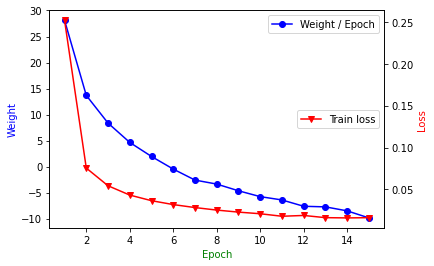

In [143]:
#Visualize the Optimization Process

# plt.plot(train_epoch,pcaVal,color="Blue")
# plt.plot(train_epoch,trainAvgLoss.values(),color="red")
# plt.title("Parameter Weight/epoch VS Loss",color="g")

fig,ax=plt.subplots()
ax.plot(train_epoch,pcaVal,color="Blue", marker="o")
ax.legend(['Weight / Epoch'],loc="upper right")
ax.set_xlabel("Epoch",color="Green")
ax.set_ylabel("Weight",color = "blue")

ax2=ax.twinx()
ax2.plot(train_epoch,trainAvgLoss.values(),color="red", marker="v")
ax2.set_xlabel("Epoch",color="Green")
ax2.set_ylabel("Loss",color = "red")
ax2.legend(['Train loss'],loc="center right")
    

plt.show()
